In [1]:
import numpy as np
%pylab
%matplotlib inline

from PIL import Image
from Functions import image_processing as ip
from Functions import seed_detection as sd
from Functions import seeded_region_growing as srg
import skimage.io as sk

# from collections import Counter

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


In [2]:
image = sk.imread("Data/N2DH-GOWT1/img/t01.tif") #Bild laden
image_resize = ip.img_resize(image, 500, 500)


C:\Users\marie\anaconda3\lib\site-packages\skimage\external\tifffile\tifffile.py:2618: RuntimeWarning: py_decodelzw encountered unexpected end of stream
  strip = decompress(strip)


C:\Users\marie\Documents\Studium\Semester4\Bioinfo\Projekt\Functions\seed_detection.py:51: RuntimeWarning: invalid value encountered in ubyte_scalars
  neighborhood_distance.append((img[p] - img[i, j]) / img[p])  # adds relative euclidean distance to list
C:\Users\marie\Documents\Studium\Semester4\Bioinfo\Projekt\Functions\seed_detection.py:51: RuntimeWarning: overflow encountered in ubyte_scalars
  neighborhood_distance.append((img[p] - img[i, j]) / img[p])  # adds relative euclidean distance to list
C:\Users\marie\Documents\Studium\Semester4\Bioinfo\Projekt\Functions\seed_detection.py:51: RuntimeWarning: divide by zero encountered in ubyte_scalars
  neighborhood_distance.append((img[p] - img[i, j]) / img[p])  # adds relative euclidean distance to list


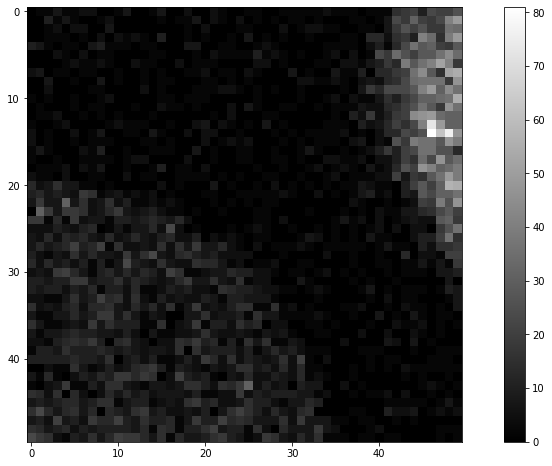

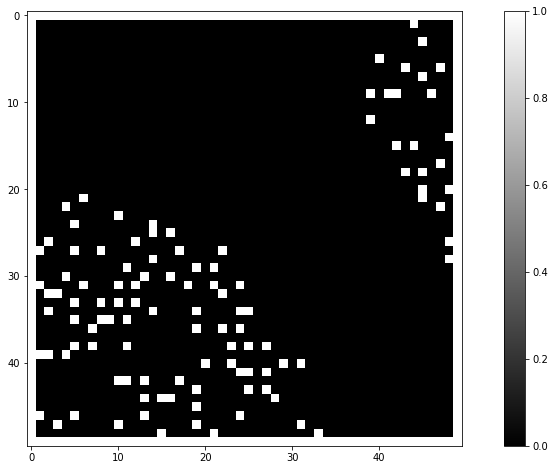

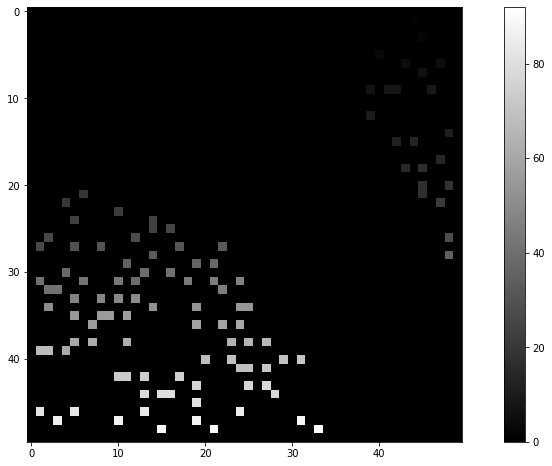

In [3]:
img_small = image[300:350, 400:450]
ip.show_image(img_small, 15, 8)
img_r = sd.seeds(img_small, 0.1, 1)
ip.show_image(img_r, 15, 8)
img_r = sd.seed_merging(img_r)
ip.show_image(img_r, 15, 8)

366
368
368
368
368
369
370
371
370
369
368
368
369
370
371
372
372
372
373
373
374
374
375
376
375
375
375
374
376
378
379
379
379
380
381
380
380
382
381
382
382
382
381
381
380
382
381
380
380
379
379
379
379
378
378
377
376
375
375
374
373
373
373
375
376
376
375
375
374
373
373
373
373
374
373
373
373
375
377
377
376
376
375
375
377
379
378
377
377
379
378
378
380
380
379
378
378
377
377
376
375
376
375
374
373
372
372
372
371
373
372
372
373
373
374
374
374
374
373
373
373
372
373
375
376
375
375
375
374
373
374
375
374
375
374
375
375
376
376
376
378
379
380
382
382
382
381
383
384
386
387
388
387
387
388
389
390
391
393
392
394
396
397
397
397
396
395
394
394
394
393
394
393
392
391
391
390
389
388
387
386
385
385
385
387
386
387
387
388
387
386
386
385
384
384
383
383
384
384
383
383
384
385
385
384
384
385
385
385
386
387
386
386
385
386
386
387
386
385
384
384
383
384
386
386
387
388
390
389
389
390
389
389
388
387
386
387
386
386
386
387
386
386
385
385
385
385
385
385
387


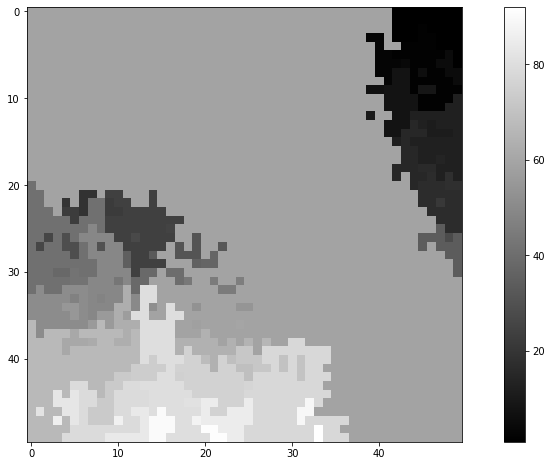

In [4]:
img_r = srg.region_growing(img_small, img_r)
ip.show_image(img_r, 15, 8)


In [5]:
#region-merging

def region_distance(img, reg):
    """
    calculates distance between all regions
    :param img: intensity values (2d array)
    :param reg: region numbers (2d array)
    :return: 2d array with distances between all regions, only in upper pyramid
    (region numbers are row and col number)
    inter_region_distances is upper triangle matrix with mean intensity distances between regions (2d array)
    mean values of all regions (list of floats)
    """

    max_region = max(reg.flatten())
    max_intensity = np.amax(img)
    inter_region_distances = np.ones((int(max_region), int(max_region)))
    means = srg.mean_region(img, reg)

    for row_number in range(0, int(max_region)):
        for col_number in range(0, int(max_region)):
            if is_upper_triangle(col_number,row_number):
                inter_region_distances[row_number][col_number] = distance_between_regions(row_number,col_number,max_intensity, means)
    return inter_region_distances, means

def is_upper_triangle(col_number, row_number):
    if col_number > row_number:
        return True
    return False

def distance_between_regions(region1, region2, max_intensity, means):
    distance = abs(means[region1] - means[region2]) / (max_intensity)
    return distance

#print(srg.mean_region(img_small, img_r))

In [6]:
def one_merged_region_mean(img, reg, region_number):
    """
    calculates the mean of changed region
    :param img: intensity values (2d array)
    :param reg: region numbers (2d array)
    :param region_number: number of the changed region (int)
    :return: mean value of changed position (float)
    """
    pos_new_reg = np.where(reg == region_number)
    single_mean = np.mean(img[pos_new_reg[0],pos_new_reg[1]])
    return single_mean


In [7]:
def region_distance_new(img, reg, pos_min_dist, means, inter_region_distances):
    """
    updates array of distances of mean intensity values between all changed regions
    :param img: intensity values (2d array)
    :param reg: region numbers (2d array)
    :param pos_min_dist: region number of changed regions (tuple(x,y), pos_min_dist[0] is resulting region number, pos_min_dist[1] is region_number to be removed)
    :param means: mean values of all regions (list of floats)
    :param inter_region_distances: distances between mean intensity values of regions (2d array)
    :return: inter_region_distances: updated distances between mean intensity values of regions
    """

    region_count = inter_region_distances.shape[0]
    maximal_intensity = np.amax(img)
    changed_region1 = int(pos_min_dist[0]) # Regions Nummer 1 die übernommen wird
    changed_region2 = int(pos_min_dist[1])
    means = update_mean_values(means, changed_region1, changed_region2, img, reg)
    inter_region_distances = update_distances(changed_region1, changed_region2, inter_region_distances, region_count, means, maximal_intensity)
    return inter_region_distances

def update_distances(changed_region1, changed_region2, inter_region_distances, region_count, means, maximal_intensity):
    """
    updates distance values of changed regions, value 500 for removed regions
    :param changed_region1: resulting region number for merged region
    :param changed_region2: region number which is going to be removed
    :param inter_region_distances: distances between mean intensity values of regions (2d array)
    :param region_count: amount of different regions at beginning of merging process (int)
    :param means: mean intensity values of regions (list)
    :param maximal_intensity: maximal intensity value of image
    :return: updated inter_region distances (2d array)
    """
    for col_number in range(changed_region1 + 1, int(region_count)):
        inter_region_distances[changed_region1][col_number] = distance_between_regions(changed_region1, col_number, maximal_intensity, means)
    for row_number in range(0, changed_region1):
        inter_region_distances[row_number][changed_region1] = distance_between_regions(changed_region1, row_number, maximal_intensity, means)
    inter_region_distances[changed_region2][0:region_count] = 500
    inter_region_distances[0:region_count][changed_region2] = 500
    return inter_region_distances

def update_mean_values(means, changed_region1, changed_region2, img, reg):
    """
    updates mean value for merged regions in list of mean values, value 500 for unused means
    :param means: mean intensity values of regions (list of ints)
    :param changed_region1: region number for merged region (int)
    :param changed_region2: region number to be removed (int)
    :param img: intensity values (2d array)
    :param reg: region numbers (2d array)
    :return:
    """
    means[changed_region2] = 500
    means[changed_region1] = one_merged_region_mean(img, reg, changed_region1 + 1)
    return means

In [8]:
def position_of_minimal_distance(dis, min_distance):
    minimal_distances = np.where(dis == min_distance)
    pos_min_dist = list(zip(minimal_distances[0], minimal_distances[1]))[0]
    pos_min_dist = (int(pos_min_dist[0]), int(pos_min_dist[1]))
    return pos_min_dist


def updates_region_numbers(inter_region_distances, reg, min_distance):
    """
    changes region number to region number of merged region
    :param inter_region_distances: distances between mean intensity values of regions (2d array)
    :param reg: region numbers (2d array)
    :param min_distance: minimal distance of mean intensity values between to regions

    :return: reg: updated region numbers (2d array)
    :return: pos_min_dist: position of minimal distance in inter_region_distances array (tuple(x,y))
    """
    pos_min_dist = position_of_minimal_distance(inter_region_distances, min_distance)

    pixel_to_change = np.where(reg == pos_min_dist[1] + 1) #column in inter_region_distances is region to be changed(column number bigger than row number)
    pixel_to_change_rows = pixel_to_change[0]
    pixel_to_change_cols = pixel_to_change[1]
    reg[pixel_to_change_rows, pixel_to_change_cols] = pos_min_dist[0] + 1
    return reg, pos_min_dist

In [9]:
def distance_merging_while(reg, threshold, img):

    """
    region merging algorithm by similarity of mean intensity values of regions
    :param reg: region numbers (2d array)
    :param threshold: distance intensity value below which regions are merged (float between 0 and 1)
    :param img: intensity value (2d array)
    :return: merged regions by intensity similarity (2d array)
    """
    result_region_distance = region_distance(img, reg)
    inter_region_distances = result_region_distance[0]
    means = result_region_distance[1]

    min_distance = np.nanmin(inter_region_distances)
    print(min_distance)
    while minimal_distance_is_similar(threshold, min_distance):
        print(1)
        updated_regions = updates_region_numbers(inter_region_distances, reg, min_distance)
        reg = updated_regions[0]
        pos_min_dist = updated_regions[1]

        inter_region_distances = region_distance_new(img, reg, pos_min_dist, means, inter_region_distances)
        min_distance = np.nanmin(inter_region_distances)
        print(min_distance)
        print(inter_region_distances)
    return reg

def minimal_distance_is_similar(threshold, min_distance):
    if min_distance < threshold:
        return True
    return False

In [ ]:
def calculate_regions_size(regions):
    max_region = np.amax(regions)
    region_sizes = []
    for region_number in range(0, max_region):
        region_count = np.sum(regions == region_number)
        region_sizes.append(region_count)
    return region_sizes

def find_neighboring_regions(regions, img, region_number):
    regions = regions.astype(int)
    pixel_of_region = np.where(regions == region_number)
    pixel_of_region = list(zip(pixel_of_region[0], pixel_of_region[1]))

    neighboring_regions = []
    for pixel in pixel_of_region:
        four_neighbors = srg.get_neighbors(img, pixel)
        for neighbor in four_neighbors:
            if regions[neighbor] != region_number and regions[neighbor] not in neighboring_regions:
                neighboring_regions.append(regions[neighbor])

def find_most_similar_region(regions, img, means, neighboring_regions):
    region_count = len(neighboring_regions)
    distances = np.ndarray(region_count)
    distances[0:region_count] =




0.0
1
0.0
[[1.         0.09001971 0.11754803 ... 0.16343904 0.083878   0.09005084]
 [1.         1.         0.20756774 ... 0.25345875 0.17389771 0.18007055]
 [1.         1.         1.         ... 0.04589101 0.03367003 0.02749719]
 ...
 [1.         1.         1.         ... 1.         0.07956104 0.0733882 ]
 [1.         1.         1.         ... 1.         1.         0.00617284]
 [1.         1.         1.         ... 1.         1.         1.        ]]
1
0.0
[[1.         0.09001971 0.11754803 ... 0.16343904 0.083878   0.09005084]
 [1.         1.         0.20756774 ... 0.25345875 0.17389771 0.18007055]
 [1.         1.         1.         ... 0.04589101 0.03367003 0.02749719]
 ...
 [1.         1.         1.         ... 1.         0.07956104 0.0733882 ]
 [1.         1.         1.         ... 1.         1.         0.00617284]
 [1.         1.         1.         ... 1.         1.         1.        ]]
1
0.0
[[1.         0.09001971 0.11754803 ... 0.16343904 0.083878   0.09005084]
 [1.         1.  

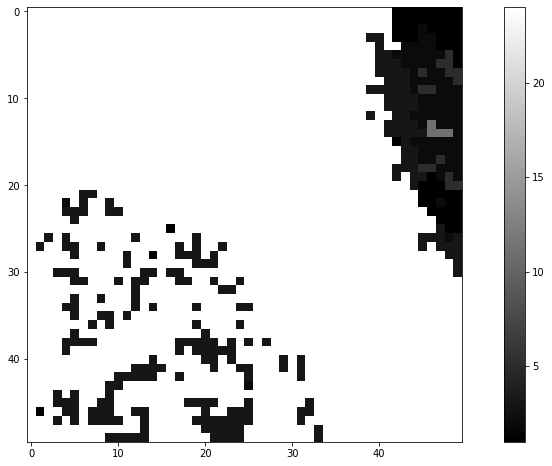

In [10]:
## Wo wird img_r überschrieben???

test = distance_merging_while(img_r, 0.1, img_small)
print(test)
ip.show_image(test, 15, 8)

#im = Image.fromarray(test)
#im.save("t01tifimg.tif")